In [21]:
import pandas as pd
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
from favorita import functions
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [2]:
df_main  =pd.read_csv('/home/emilien/code/EmilienStoret/favorita/Data/df_main_V4.csv')
df_main

,id,date,store_nbr,family,sales,onpromotion,city,holidays,holidays_nat,is_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,0,1,1,93.14
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,0,1,1,93.14
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,0,1,1,93.14
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,0,1,1,93.14
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,0,1,1,93.14
...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,0,0,0,47.57
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,0,0,0,47.57
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,0,0,0,47.57
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,0,0,0,47.57


In [3]:
df_main_store = df_main.groupby(['date']).agg({'sales':'sum', 'onpromotion':'sum', 'holidays_nat':'mean', 'dcoilwtico':'mean'}) 
df_main_store.reset_index(inplace=True)


In [4]:
df_main_store

,date,sales,onpromotion,holidays_nat,dcoilwtico
0,2013-01-01,2511.618999,0,1.0,93.14
1,2013-01-02,496092.417944,0,0.0,93.14
2,2013-01-03,361461.231124,0,0.0,92.97
3,2013-01-04,354459.677093,0,0.0,93.12
4,2013-01-05,477350.121229,0,1.0,93.12
...,...,...,...,...,...
1679,2017-08-11,826373.722022,14179,1.0,48.81
1680,2017-08-12,792630.535079,8312,0.0,48.81
1681,2017-08-13,865639.677471,9283,0.0,48.81
1682,2017-08-14,760922.406081,8043,0.0,47.59


In [5]:
functions.get_baseline_score(df_main_store)

/home/emilien/code/EmilienStoret/favorita/favorita/functions.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'date': 'ds', 'sales':'y'}, inplace=True)


0.07713509154140698

# prepare the dataset

In [6]:
df_main_store.rename(columns={'date':'ds','sales':'y', 'holidays_nat':'is_holiday'}, inplace = True)
df_train = df_main_store[df_main_store['ds']<'2017-04-01']
df_test = df_main_store[(df_main_store['ds']>='2017-04-01')&(df_main_store['ds']<'2017-07-01')]

# Launch grid search

In [7]:
# import itertools

# # Create parameter grid
# params_grid = {'seasonality_mode':(['additive']),
#                'changepoint_range':[0.8],
#                'changepoint_prior_scale':[0.05,0.1,0.7],
#                'seasonality_prior_scale':[0.05, 0.1, 0.4],
#                'prior_scale_is_holiday':[0.1],
#                'prior_scale_onpromotion':[0.0002, 0.002, 0.02, 0.2],
#                'prior_scale_dcoilwtico':[0.0001],
#                'fourier_order':[5]
#               }

# # Get all the model parameters in a list of dictionary
# grid = ParameterGrid(params_grid)

# mdape = []  # Store the MDAPE for each params here

# for p in tqdm(grid):
#     m = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                 changepoint_range=p['changepoint_range'],
#                          seasonality_prior_scale = p['seasonality_prior_scale'],
#                          seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality = False,
#                          yearly_seasonality = True,
#                          interval_width=0.95)
#     m.add_regressor('is_holiday', prior_scale = p['prior_scale_is_holiday'])
#     m.add_regressor('onpromotion', prior_scale = p['prior_scale_onpromotion'])
#     m.add_regressor('dcoilwtico', prior_scale = p['prior_scale_dcoilwtico'])
#     m.add_seasonality(name='monthly', period=30.417, fourier_order=p['fourier_order'])
#     model=m.fit(df_train[['ds', 'y', 'is_holiday', 'onpromotion', 'dcoilwtico']])
    
#     df_cv = cross_validation(m, horizon='91 days',initial = '1095 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     mdape.append(df_p['mdape'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(grid)
# tuning_results['mdape'] = mdape
# print(tuning_results)

In [8]:
import itertools

# Create parameter grid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_range':[0.8],
               'changepoint_prior_scale':[0.7],
               'seasonality_prior_scale':[0.4],
               'prior_scale_is_holiday':[0.1],
               'prior_scale_onpromotion':[0.002],
               'prior_scale_dcoilwtico':[0.0001],
               'fourier_order':[5]
              }

# Get all the model parameters in a list of dictionary
grid = ParameterGrid(params_grid)

mdape = []  # Store the MDAPE for each params here

for p in tqdm(grid):
    m = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                changepoint_range=p['changepoint_range'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = False,
                         yearly_seasonality = True,
                         interval_width=0.95)
    m.add_regressor('is_holiday', prior_scale = p['prior_scale_is_holiday'])
    m.add_regressor('onpromotion', prior_scale = p['prior_scale_onpromotion'])
    m.add_regressor('dcoilwtico', prior_scale = p['prior_scale_dcoilwtico'])
    m.add_seasonality(name='monthly', period=30.417, fourier_order=p['fourier_order'])
    model=m.fit(df_train[['ds', 'y', 'is_holiday', 'onpromotion', 'dcoilwtico']])
    
    df_cv = cross_validation(m, horizon='91 days',initial = '1095 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mdape.append(df_p['mdape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['mdape'] = mdape
print(tuning_results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]

   changepoint_prior_scale  changepoint_range  fourier_order  \
0                      0.7                0.8              5   

   prior_scale_dcoilwtico  prior_scale_is_holiday  prior_scale_onpromotion  \
0                  0.0001                     0.1                    0.002   

  seasonality_mode  seasonality_prior_scale     mdape  
0         additive                      0.4  0.082836  


In [9]:
df_best_params = tuning_results[tuning_results['mdape']==tuning_results['mdape'].min()]
index = df_best_params.index[0]

In [10]:
m = Prophet(changepoint_prior_scale = df_best_params['changepoint_prior_scale'][index],
            seasonality_prior_scale = df_best_params['seasonality_prior_scale'][index],
            changepoint_range=df_best_params['changepoint_range'][index],
            seasonality_mode = df_best_params['seasonality_mode'][index],
            weekly_seasonality=True,
            daily_seasonality = False,
            yearly_seasonality = True,
            interval_width=0.95)
m.add_regressor('is_holiday', prior_scale = df_best_params['prior_scale_is_holiday'][index])
m.add_regressor('onpromotion', prior_scale = df_best_params['prior_scale_onpromotion'][index])
m.add_regressor('dcoilwtico', prior_scale = df_best_params['prior_scale_dcoilwtico'][index])
m.add_seasonality(name='monthly', period=30.417, fourier_order=df_best_params['fourier_order'][index])
model=m.fit(df_train[['ds', 'y', 'is_holiday', 'onpromotion', 'dcoilwtico']])

#forecast from prophet
df_loop = df_main_store
future=m.make_future_dataframe(periods=91, freq= 'D')
future.insert(1, 'is_holiday', df_loop['is_holiday'])
future.insert(2, 'onpromotion', df_loop['onpromotion'])
future.insert(3, 'dcoilwtico', df_loop['dcoilwtico'])
df_store_main_pred = m.predict(future)

In [11]:
df_store_main_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,311266.064094,278402.808498,6.572803e+05,311266.064094,311266.064094,159354.292197,159354.292197,159354.292197,0.591037,...,-66634.315718,-66634.315718,-66634.315718,104204.183194,104204.183194,104204.183194,0.0,0.0,0.0,470620.356291
1,2013-01-02,311906.101934,199893.908332,5.921272e+05,311906.101934,311906.101934,80920.581574,80920.581574,80920.581574,0.591037,...,-59241.853959,-59241.853959,-59241.853959,95345.403125,95345.403125,95345.403125,0.0,0.0,0.0,392826.683508
2,2013-01-03,312546.139774,112210.337386,5.257749e+05,312546.139774,312546.139774,1478.203864,1478.203864,1478.203864,0.586752,...,-121863.581739,-121863.581739,-121863.581739,86593.675591,86593.675591,86593.675591,0.0,0.0,0.0,314024.343638
3,2013-01-04,313186.177614,152431.554018,5.557262e+05,313186.177614,313186.177614,36052.138329,36052.138329,36052.138329,0.590533,...,-70902.691933,-70902.691933,-70902.691933,78092.787114,78092.787114,78092.787114,0.0,0.0,0.0,349238.315943
4,2013-01-05,313826.215455,421249.889509,8.228799e+05,313826.215455,313826.215455,306060.047401,306060.047401,306060.047401,0.590533,...,138342.616544,138342.616544,138342.616544,69974.135248,69974.135248,69974.135248,0.0,0.0,0.0,619886.262856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2017-06-26,782854.263050,448095.964677,1.005992e+06,557921.313448,975963.030399,-43203.249494,-43203.249494,-43203.249494,-0.666806,...,-15442.092040,-15442.092040,-15442.092040,-20876.622614,-20876.622614,-20876.622614,0.0,0.0,0.0,739651.013557
1634,2017-06-27,782932.109358,414334.875397,9.602677e+05,553618.152380,979309.222102,-83792.203829,-83792.203829,-83792.203829,-0.641347,...,-66634.315718,-66634.315718,-66634.315718,-21765.884935,-21765.884935,-21765.884935,0.0,0.0,0.0,699139.905529
1635,2017-06-28,783009.955667,475954.623658,1.038088e+06,549314.991311,982655.413805,-12954.524383,-12954.524383,-12954.524383,-0.628995,...,-59241.853959,-59241.853959,-59241.853959,-22430.519582,-22430.519582,-22430.519582,0.0,0.0,0.0,770055.431284
1636,2017-06-29,783087.801975,373536.110906,9.526384e+05,545016.149777,986001.605508,-82580.615477,-82580.615477,-82580.615477,-0.625466,...,-121863.581739,-121863.581739,-121863.581739,-22839.132535,-22839.132535,-22839.132535,0.0,0.0,0.0,700507.186497


# Analysis of the predictions

In [12]:
df_store_main_pred_only=df_store_main_pred[(df_store_main_pred['ds']>='2017-04-01')&(df_store_main_pred['ds']<'2017-07-01')]

mape = abs((df_store_main_pred_only['yhat']-df_test['y'])
            /df_test['y'])
mape.mean()

0.06726801568312817

In [13]:
df_best_params

,changepoint_prior_scale,changepoint_range,fourier_order,prior_scale_dcoilwtico,prior_scale_is_holiday,prior_scale_onpromotion,seasonality_mode,seasonality_prior_scale,mdape
0,0.7,0.8,5,0.0001,0.1,0.002,additive,0.4,0.082836


# Get the forecast values and charts for the streamlit

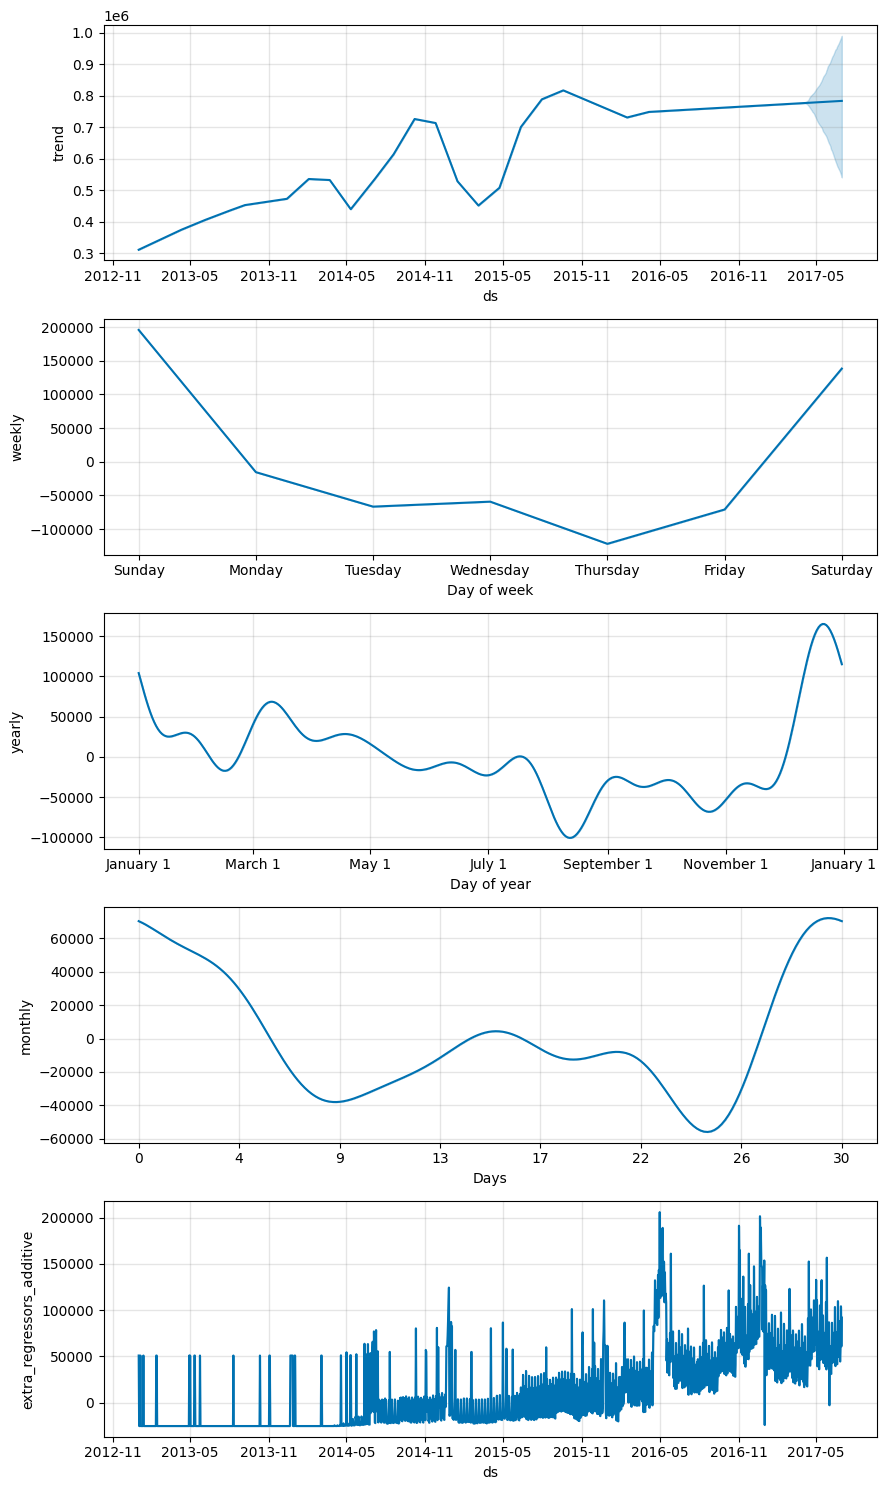

In [14]:
fig = m.plot_components(df_store_main_pred)

In [16]:
df_store_main_pred_only

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1547,2017-04-01,776159.480549,825199.836079,1.230789e+06,776159.480549,776159.480549,249852.175213,249852.175213,249852.175213,-0.482793,...,138342.616544,138342.616544,138342.616544,20395.914762,20395.914762,20395.914762,0.0,0.0,0.0,1.026012e+06
1548,2017-04-02,776237.326857,878669.414332,1.297167e+06,776237.326857,776237.326857,312981.158443,312981.158443,312981.158443,-0.482793,...,195741.918844,195741.918844,195741.918844,19978.711526,19978.711526,19978.711526,0.0,0.0,0.0,1.089218e+06
1549,2017-04-03,776315.173166,647550.402918,1.059439e+06,776315.173166,776500.688558,85599.038650,85599.038650,85599.038650,-0.490103,...,-15442.092039,-15442.092039,-15442.092039,19851.470464,19851.470464,19851.470464,0.0,0.0,0.0,8.619142e+05
1550,2017-04-04,776393.019474,618607.883298,1.026402e+06,776130.512117,776873.438334,44071.576158,44071.576158,44071.576158,-0.471450,...,-66634.315718,-66634.315718,-66634.315718,19984.460850,19984.460850,19984.460850,0.0,0.0,0.0,8.204646e+05
1551,2017-04-05,776470.865782,670543.696657,1.062849e+06,775696.232874,777472.617824,81840.723045,81840.723045,81840.723045,-0.467669,...,-59241.853959,-59241.853959,-59241.853959,20343.332655,20343.332655,20343.332655,0.0,0.0,0.0,8.583116e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2017-06-26,782854.263050,448095.964677,1.005992e+06,557921.313448,975963.030399,-43203.249494,-43203.249494,-43203.249494,-0.666806,...,-15442.092040,-15442.092040,-15442.092040,-20876.622614,-20876.622614,-20876.622614,0.0,0.0,0.0,7.396510e+05
1634,2017-06-27,782932.109358,414334.875397,9.602677e+05,553618.152380,979309.222102,-83792.203829,-83792.203829,-83792.203829,-0.641347,...,-66634.315718,-66634.315718,-66634.315718,-21765.884935,-21765.884935,-21765.884935,0.0,0.0,0.0,6.991399e+05
1635,2017-06-28,783009.955667,475954.623658,1.038088e+06,549314.991311,982655.413805,-12954.524383,-12954.524383,-12954.524383,-0.628995,...,-59241.853959,-59241.853959,-59241.853959,-22430.519582,-22430.519582,-22430.519582,0.0,0.0,0.0,7.700554e+05
1636,2017-06-29,783087.801975,373536.110906,9.526384e+05,545016.149777,986001.605508,-82580.615477,-82580.615477,-82580.615477,-0.625466,...,-121863.581739,-121863.581739,-121863.581739,-22839.132535,-22839.132535,-22839.132535,0.0,0.0,0.0,7.005072e+05


In [52]:
df_store_main_pred_only['Month']=df_store_main_pred_only['ds'].dt.month

/tmp/ipykernel_7816/3734089408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_main_pred_only['Month']=df_store_main_pred_only['ds'].dt.month


In [53]:
df_store_main_pred_only

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,month,Month
1547,2017-04-01,776159.480549,825199.836079,1.230789e+06,776159.480549,776159.480549,249852.175213,249852.175213,249852.175213,-0.482793,...,138342.616544,20395.914762,20395.914762,20395.914762,0.0,0.0,0.0,1.026012e+06,4,4
1548,2017-04-02,776237.326857,878669.414332,1.297167e+06,776237.326857,776237.326857,312981.158443,312981.158443,312981.158443,-0.482793,...,195741.918844,19978.711526,19978.711526,19978.711526,0.0,0.0,0.0,1.089218e+06,4,4
1549,2017-04-03,776315.173166,647550.402918,1.059439e+06,776315.173166,776500.688558,85599.038650,85599.038650,85599.038650,-0.490103,...,-15442.092039,19851.470464,19851.470464,19851.470464,0.0,0.0,0.0,8.619142e+05,4,4
1550,2017-04-04,776393.019474,618607.883298,1.026402e+06,776130.512117,776873.438334,44071.576158,44071.576158,44071.576158,-0.471450,...,-66634.315718,19984.460850,19984.460850,19984.460850,0.0,0.0,0.0,8.204646e+05,4,4
1551,2017-04-05,776470.865782,670543.696657,1.062849e+06,775696.232874,777472.617824,81840.723045,81840.723045,81840.723045,-0.467669,...,-59241.853959,20343.332655,20343.332655,20343.332655,0.0,0.0,0.0,8.583116e+05,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,2017-06-26,782854.263050,448095.964677,1.005992e+06,557921.313448,975963.030399,-43203.249494,-43203.249494,-43203.249494,-0.666806,...,-15442.092040,-20876.622614,-20876.622614,-20876.622614,0.0,0.0,0.0,7.396510e+05,6,6
1634,2017-06-27,782932.109358,414334.875397,9.602677e+05,553618.152380,979309.222102,-83792.203829,-83792.203829,-83792.203829,-0.641347,...,-66634.315718,-21765.884935,-21765.884935,-21765.884935,0.0,0.0,0.0,6.991399e+05,6,6
1635,2017-06-28,783009.955667,475954.623658,1.038088e+06,549314.991311,982655.413805,-12954.524383,-12954.524383,-12954.524383,-0.628995,...,-59241.853959,-22430.519582,-22430.519582,-22430.519582,0.0,0.0,0.0,7.700554e+05,6,6
1636,2017-06-29,783087.801975,373536.110906,9.526384e+05,545016.149777,986001.605508,-82580.615477,-82580.615477,-82580.615477,-0.625466,...,-121863.581739,-22839.132535,-22839.132535,-22839.132535,0.0,0.0,0.0,7.005072e+05,6,6


In [55]:
df_dataviz = df_store_main_pred_only.groupby(['Month']).agg({'yhat':'mean'}) 
df_dataviz.reset_index(inplace=True)
df_dataviz

,Month,yhat
0,4,868335.363349
1,5,841413.292707
2,6,821100.207676


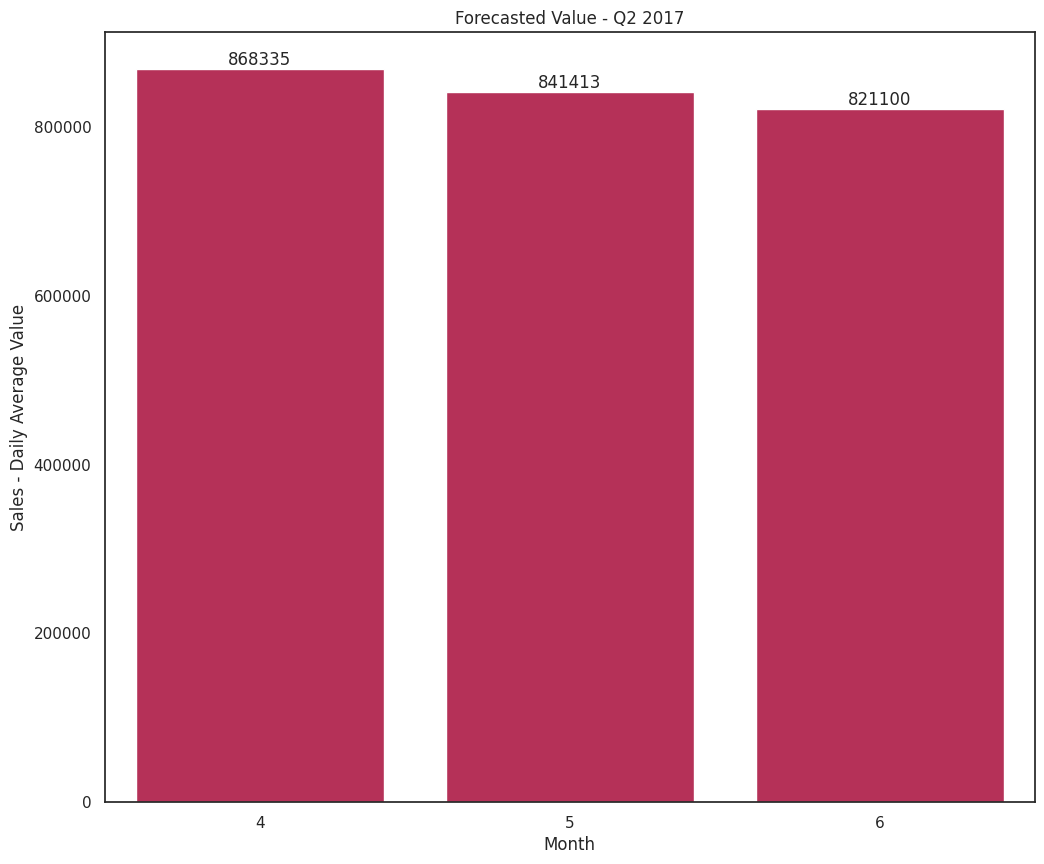

In [104]:
sns.set_theme(style="white")
palette = sns.color_palette("rocket", 1)
bar = sns.barplot(df_dataviz, x='Month', y='yhat', palette=palette)
bar.set_title('Forecasted Value - Q2 2017')
bar.set_ylabel('Sales - Daily Average Value')
sns.set(rc={'figure.figsize':(12,10)})
for i in bar.containers:
        bar.bar_label(i,)
fig.savefig("Q2_2017.png")

In [60]:
df_dataviz_april = df_store_main_pred_only[df_store_main_pred_only['Month']==4]
df_dataviz_april

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,month,Month
1547,2017-04-01,776159.480549,825199.836079,1.230789e+06,776159.480549,776159.480549,249852.175213,249852.175213,249852.175213,-0.482793,...,138342.616544,20395.914762,20395.914762,20395.914762,0.0,0.0,0.0,1.026012e+06,4,4
1548,2017-04-02,776237.326857,878669.414332,1.297167e+06,776237.326857,776237.326857,312981.158443,312981.158443,312981.158443,-0.482793,...,195741.918844,19978.711526,19978.711526,19978.711526,0.0,0.0,0.0,1.089218e+06,4,4
1549,2017-04-03,776315.173166,647550.402918,1.059439e+06,776315.173166,776500.688558,85599.038650,85599.038650,85599.038650,-0.490103,...,-15442.092039,19851.470464,19851.470464,19851.470464,0.0,0.0,0.0,8.619142e+05,4,4
1550,2017-04-04,776393.019474,618607.883298,1.026402e+06,776130.512117,776873.438334,44071.576158,44071.576158,44071.576158,-0.471450,...,-66634.315718,19984.460850,19984.460850,19984.460850,0.0,0.0,0.0,8.204646e+05,4,4
1551,2017-04-05,776470.865782,670543.696657,1.062849e+06,775696.232874,777472.617824,81840.723045,81840.723045,81840.723045,-0.467669,...,-59241.853959,20343.332655,20343.332655,20343.332655,0.0,0.0,0.0,8.583116e+05,4,4
1552,2017-04-06,776548.712090,519066.568878,9.481518e+05,775356.753526,778554.173587,-42565.615270,-42565.615270,-42565.615270,-0.453805,...,-121863.581739,20890.302651,20890.302651,20890.302651,0.0,0.0,0.0,7.339831e+05,4,4
1553,2017-04-07,776626.558398,601775.865973,1.001778e+06,774878.559854,779416.028358,27238.116672,27238.116672,27238.116672,-0.439689,...,-70902.691934,21585.357617,21585.357617,21585.357617,0.0,0.0,0.0,8.038647e+05,4,4
1554,2017-04-08,776704.404706,765210.834250,1.145126e+06,774019.925508,780444.713981,182780.294836,182780.294836,182780.294836,-0.439689,...,138342.616544,22387.439261,22387.439261,22387.439261,0.0,0.0,0.0,9.594847e+05,4,4
1555,2017-04-09,776782.251015,813646.892665,1.208343e+06,773489.041654,781029.654902,225142.369052,225142.369052,225142.369052,-0.439689,...,195741.918844,23255.577767,23255.577767,23255.577767,0.0,0.0,0.0,1.001925e+06,4,4
1556,2017-04-10,776860.097323,570706.465121,9.720579e+05,772505.177388,782325.412062,-9247.029940,-9247.029940,-9247.029940,-0.419271,...,-15442.092039,24149.944131,24149.944131,24149.944131,0.0,0.0,0.0,7.676131e+05,4,4


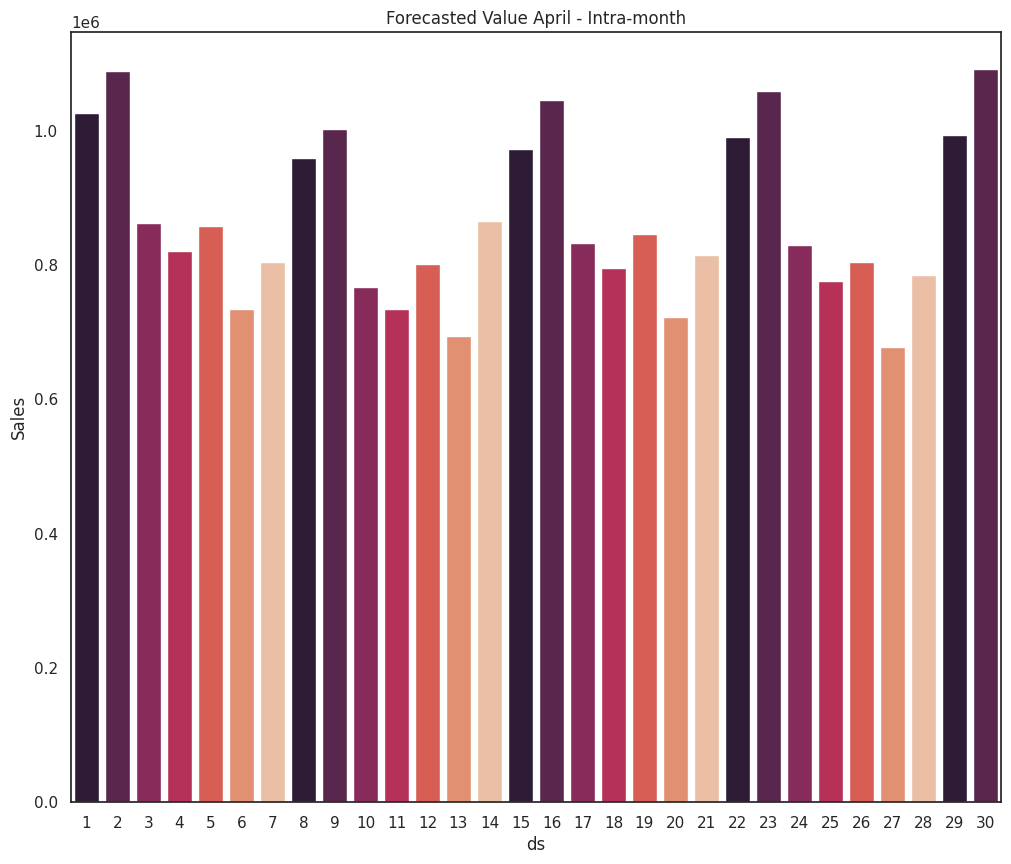

In [105]:
#bar1.set_palette(sns.color_palette("rocket"))
x_value = range(1, 31)
#sns.set_palette(sns.color_palette("crest"))
sns.set_theme(style="white")
palette = sns.color_palette("rocket", 7)
bar1 = sns.barplot(df_dataviz_april, x='ds', y='yhat', palette = palette)
bar1.set_title('Forecasted Value April - Intra-month')
bar1.set_ylabel('Sales')
bar1.set_xticklabels(x_value)
sns.set(rc={'figure.figsize':(17,10)})
fig.savefig("April_2017.png")